In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import dask.dataframe as dd
from geopy.distance import geodesic

import warnings
warnings.filterwarnings('ignore')

Load the data...

In [3]:
#df = pd.read_csv('../csv/credit_card_fraud_2019_q1.csv')
df = pd.read_csv('csv/credit_card_fraud_sample_10K.csv')

In [4]:
# Set Pandas options to display full rows
pd.set_option('display.max_colwidth', None)  # Show full column contents
pd.set_option('display.max_columns', None)  # Show all columns
#pd.set_option('display.width', 1000)  # Adjust width for full display
#pd.set_option('display.max_rows', None)  # Show all rows (use with caution for large datasets)

In [ ]:
df.head()

In [ ]:
df.isna().sum()

Clean the Data
1. consider drop first/last name, ssn, cc_num, trans_num etc...
2. explore locational data e.g zip lat/long, city etc... TBD replace with regions??
3. reorganize date & time data:
    3.1 work day vs weekend
    3.2 TBD: split hour segment, work/sleep/free hours
4. set 4 age groups youngest to oldest (18-199), teenager (-18) young_adult (19-25), adult (26-65), retired (...)
    4.1 TBD treat different for men & women?? retirement age 66(M), 63(F)

5. categorize: category,          

6. explore: amt, dob? 


In [ ]:
df.info()

In [9]:
df.rename(columns={'Unnamed: 0':'id'}, inplace=True)

In [ ]:
print(df['gender'].value_counts())
df['gender'] = df['gender'].map({'M': 1, 'F': 0})
print(df['gender'].value_counts())


## Create a time delta between 2 consequent transactions using the unix time.

##Handle date time related data

In [ ]:
def assign_time_segment(hour):
    if 0 <= hour < 6:
        return 'Late_Night_0-6'
    elif 6 <= hour < 12:
        return 'Morning_6-12'
    elif 12 <= hour < 18:
        return 'Afternoon_12-18'
    else:
        return 'Evening_18-24'

def assign_age_group(age):
    if age < 15:
        return 'child'
    elif age < 20:
        return 'teenager'
    elif age < 40:
        return 'young_adult'
    elif age < 60:
        return 'middle_aged'
    elif age < 80:
        return 'senior'
    else:
        return 'elderly'

df['trans_date'] = pd.to_datetime(df['trans_date'])
df['trans_time'] = pd.to_datetime(df['trans_time'])

df['trans_year'] = df['trans_date'].dt.year
df['trans_month'] = df['trans_date'].dt.month
df['trans_day'] = df['trans_date'].dt.day

#df['trans_hour'] = df['trans_time'].dt.hour
#df['trans_minute'] =df['trans_time'].dt.minute
#df['trans_second'] =df['trans_time'].dt.second
df['trans_time_segment'] = df['trans_time'].dt.hour.apply(assign_time_segment)

#df['dob'] = pd.to_datetime(df['dob'])
#df['age'] = df['trans_year']  - df['dob'].dt.year
df['age_group'] = (df['trans_year'] -pd.to_datetime(df['dob']).dt.year).apply(assign_age_group)


In [ ]:
df['age_group'].value_counts()

## Categorize CC numbers

In [ ]:
#credit card types

# Function to determine credit card type based on the first 4 digits
def get_cc_type(cc_num):
    cc_num = str(cc_num)
    first_four = int(cc_num[:4]) if cc_num[:4].isdigit() else None

    if first_four is None:
        return "Unknown_none"
    elif 4000 <= first_four <= 4999:
        return "Visa"
    elif 5100 <= first_four <= 5599 or 2221 <= first_four <= 2720:
        return "MasterCard"
    elif 3400 <= first_four <= 3499 or 3700 <= first_four <= 3799:
        return "American_Express"
    elif 6011 == first_four or 6221 <= first_four <= 6229 or 6440 <= first_four <= 6499 or 6500 <= first_four <= 6599:
        return "Discover"
    elif 3000 <= first_four <= 3059 or first_four // 100 == 36 or first_four // 100 == 38:     #first_four in [36, 38]:
        return "Diners_Club"
    elif 3528 <= first_four <= 3589:
        return "JCB"
    else:
        return f"Unknown"

# Apply function to extract 'cc_type'
df['cc_type'] = df['cc_num'].apply(get_cc_type)


## Categorize poppulations by size

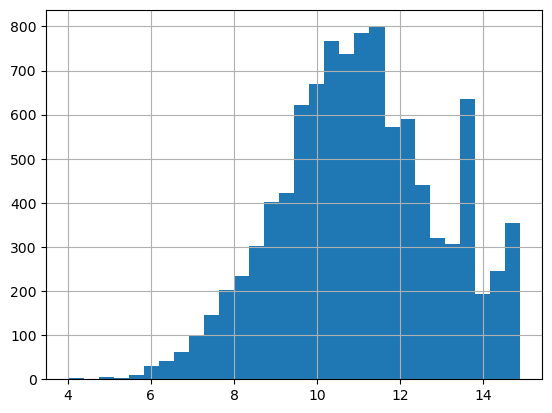

In [ ]:
'''
Opt one, decided not to use it since it is highly skewed to the right
# Define custom categories based on population size
bins_custom = [0, 5000, 20000, 100000, 500000, 1000000, 3000000]  # 6 bins
labels_custom = ['Very Small', 'Small', 'Medium', 'Large', 'Very Large', 'Metropolis']

# Create categorical column
df['city_pop_cat'] = pd.cut(df['city_pop'], bins=bins_custom, labels=labels_custom, include_lowest=True)

# Display the distribution of categories
df['city_pop_cat'].value_counts()'
'''
#Opt two, decided to use log transformation to make it more normal
df['city_pop_log'] = np.log1p(df['city_pop'])

#df['city_pop_log'].hist(bins=30)
#plt.show()


## Formulate customer to merchant distance

In [ ]:
# Function to calculate distance between user and merchant locations
def calculate_distance(row):
    user_location = (row['lat'], row['long'])
    merchant_location = (row['merch_lat'], row['merch_long'])
    return geodesic(user_location, merchant_location).kilometers

# Apply distance calculation
df['distance'] = df.apply(calculate_distance, axis=1)

print(df['distance'].describe())
print('skewness', df['distance'].skew()) # -0.24, largely symmetrical distribution with a slight pull to the left

# Display the distribution of distances 
plt.figure(figsize=(10, 6))
sns.histplot(df['distance'], bins=30, kde=True)

distance_bins = [0, 20, 50, 100, 150]  # Ranges for categorization
distance_labels = ["local_0-20_km", "close_21-50_km", "moderate_51-100_km", "far_101-150_km"]

# Create a new column with distance categories
df['distance_category'] = pd.cut(df['distance'], bins=distance_bins, labels=distance_labels, include_lowest=True)

df.head()

## Categorize Jobs - TBD requires further improvement!!!

In [ ]:

def categorize_jobs(df, job_column="job"):
    """
    Categorizes jobs based on keywords derived from the latest refined job mapping
    and creates a new column 'job_cat'.
    
    Parameters:
    df (DataFrame): The dataframe containing the job column.
    job_column (str): The name of the column that contains job titles.
    
    Returns:
    DataFrame: The dataframe with a new column 'job_cat' containing the job categories.
    """
    # Define the latest refined job mapping
    refined_job_mapping = {
        "Healthcare & Medical": ["Nurse", "Midwife", "Immunologist", "Mental health nurse", "Child psychotherapist", 
                                  "Speech and language therapist", "Clinical molecular geneticist", "Scientist",
                                  "Doctor", "Physician", "Surgeon", "Hospital doctor", "General practitioner",
                                  "Clinical scientist", "Radiologist", "Psychiatrist", "Dentist", "Optometrist",
                                  "Pharmacist", "Therapist", "Physiotherapist", "Oncologist", "Neurologist",
                                  "Cardiologist", "Pediatrician", "Endocrinologist", "Urologist", "Chiropractor",
                                  "Anesthesiologist", "Dietitian", "Orthodontist", "Paramedic", "Occupational therapist",
                                  "General practice doctor", "Health physicist", "Radiographer, therapeutic", "Psychologist, clinical",
                                  "Orthoptist", "Ophthalmologist", "Haematologist", "Pathologist", "Toxicologist",
                                  "Homeopath", "Nurse, mental health", "Optician", "Ambulance", "Health"],
        "Engineering & Technical": ["Engineer", "Automotive engineer", "Water engineer", "Operations geologist", 
                                    "Electrical engineer", "Mechanical engineer", "Chemical engineer", "Civil engineer",
                                    "Aerospace engineer", "Biomedical engineer", "Environmental engineer", "Structural engineer", 
                                    "Industrial engineer", "Mining engineer", "Engineer, control and instrumentation",
                                    "Technologist", "Technician", "Hydrologist", "Hydrogeologist", "Arboriculturist", "Tree surgeon"],
        "Software & IT": ["IT consultant", "Software developer", "Data scientist", "Cybersecurity analyst",
                          "System administrator", "Network engineer", "Telecom specialist", "Machine learning engineer", 
                          "Robotics engineer", "AI specialist", "DevOps engineer", "Database administrator", "Web developer",
                          "Cloud architect", "Game developer", "Games", "Application", "Programmer", "Systems developer"],
        "Education & Training": ["Teacher", "Outdoor activities/education manager", "Professor", "Lecturer", "Tutor",
                                 "Trainer", "Instructional designer", "Education consultant", "Principal", "School counselor",
                                 "Curriculum developer", "Teacher, secondary school", "Librarian"],
        "Finance & Accounting": ["Dealer", "Financial analyst", "Accountant", "Auditor", "Investment banker", 
                                 "Economist", "Bank manager", "Actuary", "Tax consultant", "Insurance agent",
                                 "Financial planner", "Risk analyst", "Loan officer", "Financial adviser", 
                                 "Accountant, chartered public finance", "Tax", "Trader", "Investment", "Insurance"],
        "Business & Management": ["Facilities manager", "Event organiser", "Project manager", "Operations manager", 
                                  "HR manager", "Business consultant", "Strategy consultant", "Executive director",
                                  "Entrepreneur", "Supply chain manager", "Management consultant", "Secretary", "Executive",
                                  "Officer", "Director", "Administrator"],
        "Government & Public Sector": ["Research officer, government", "Surveyor, building control", "Information officer", 
                                       "Policy analyst", "Public relations officer", "Government administrator", "Urban planner", 
                                       "Customs officer", "Diplomat", "Legislative assistant", "Forensic scientist"],
        "Creative & Media": ["Printmaker", "Graphic designer", "Journalist", "Photographer", "Videographer", 
                             "Illustrator", "Animator", "Film director", "Content creator", "Editor", "Copywriter", 
                             "Fashion designer", "Interior designer", "Colour technologist", "Camera", "Broadcast", 
                             "Magazine", "Broadcasting", "Film", "Video", "Designer", "Television", "Theatre", "Radio"],
        "Consulting": ["Business consultant", "IT consultant", "Strategy consultant", "Legal consultant", "Adviser", "Advice"],
        "Agriculture & Environmental": ["Farmer", "Agronomist", "Food scientist", "Environmental scientist", "Ecologist", "Park ranger", "Forestry technician",
                                          "Hydrologist", "Hydrogeologist", "Herpetologist", "Arboriculturist", "Tree surgeon"],
    }
    
    # Categorize job based on keyword matching
    def find_category(job_title):
        for category, keywords in refined_job_mapping.items():
            if any(keyword.lower() in job_title.lower() for keyword in keywords):
                return category
        return "Other"
    
    # Apply categorization function to the job column
    df["job_cat"] = df[job_column].apply(find_category)
    
    return df



# Apply the function to categorize jobs in the dataset
df = categorize_jobs(df, job_column="job")

# Display first few rows to confirm
df.head()
df['job_cat'].value_counts()

In [ ]:
# set area
#df['profile'] = df['profile'].str.replace('.json', '') 
# Extract the area (last word before .json)
df['area'] = df['profile'].str.extract(r'_(rural|urban)\.json')

print(df['area'].value_counts())

In [ ]:
df.info()

In [37]:
df['ssn'] = df['ssn'].astype('string')
df['street'] = df['street'].astype('string')
df['city'] = df['city'].astype('string')
df['state'] = df['state'].astype('string')
df['profile'] = df['profile'].astype('string')
df['trans_num'] = df['trans_num'].astype('string')
df['category'] = df['category'].astype('string')
df['merchant'] = df['merchant'].astype('string')
df['cc_type'] = df['cc_type'].astype('string')
df['age_group'] = df['age_group'].astype('string')
df['trans_time_segment'] = df['trans_time_segment'].astype('string')
df['distance_category'] = df['distance_category'].astype('string')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  10000 non-null  int64         
 1   ssn                 10000 non-null  string        
 2   cc_num              10000 non-null  int64         
 3   first               10000 non-null  object        
 4   last                10000 non-null  object        
 5   gender              10000 non-null  object        
 6   street              10000 non-null  string        
 7   city                10000 non-null  string        
 8   state               10000 non-null  string        
 9   zip                 10000 non-null  int64         
 10  lat                 10000 non-null  float64       
 11  long                10000 non-null  float64       
 12  city_pop            10000 non-null  int64         
 13  job                 10000 non-null  object     

area
urban    3058679
rural     167602
Name: count, dtype: Int64


In [ ]:
#potential dropouts
#['ssn','cc_num', 'trans_num', 'first','last','dob']
